In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [2]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

data, data_labels = [],[]
H, W = 365, 547
for file in os.listdir('./PCIA-Data'):
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = cv2.imread('./PCIA-Data/'+file)
    img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
    data.append(img_new)
    data_labels.append(0)

#print(len(data))



In [3]:
active_count = 0
for file in os.listdir('./PCIA_Active_imgs'):
  if active_count > 31:
    break
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = cv2.imread('./PCIA_Active_imgs/'+file)
    img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
    data.append(img_new)
    data_labels.append(1)
    active_count += 1
#cv2_imshow(img_new)

(365, 547, 3)


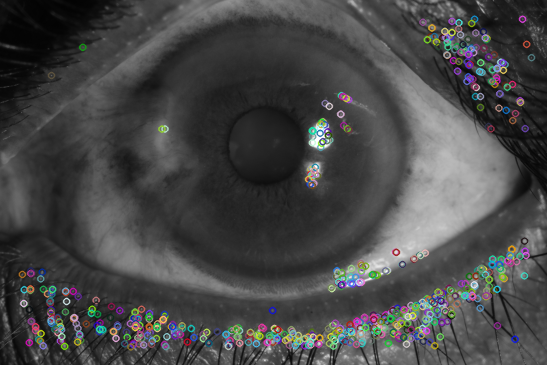

(686, 64)
686


In [14]:
##test
print(img_new.shape)
img_test = cv2.cvtColor(data[5], cv2.COLOR_BGR2GRAY)
brisk = cv2.BRISK_create(30)
kpts, des = brisk.detectAndCompute(img_test, None)
sift_image = cv2.drawKeypoints(img_test, kpts, img_new)
#img2 = cv2.drawKeypoints(img_test, kpts, None, color=(0,255,0), flags=0)
cv2_imshow(sift_image)
print(des.shape)
print(len(kpts))

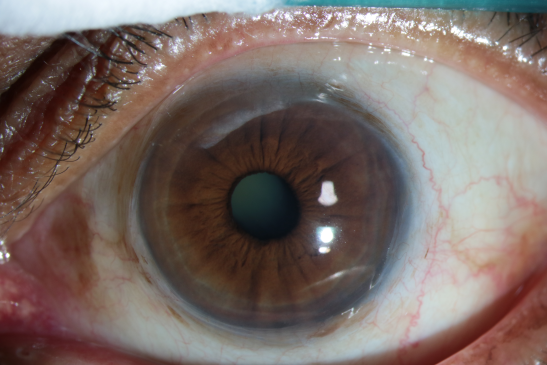

(24948,)


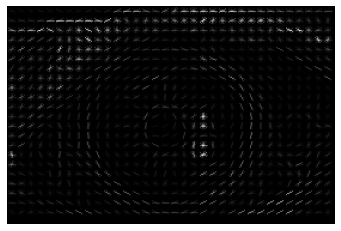

In [5]:
from skimage.feature import hog
import matplotlib.pyplot as plt
temp = cv2.resize(data[0], None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
fd, hog_image = hog(temp, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
cv2_imshow(data[0])
print(fd.shape)

In [5]:
print(h.shape)

(6917400, 1)


In [ ]:
print(data[0].shape)

(365, 547, 3)


In [15]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 4.9MB/s 


In [16]:
import mahotas
print(len(data))
feature_data = []
for i in range(len(data)):
  gray = cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)
  # compute the haralick texture feature vector
  haralick = mahotas.features.haralick(gray).mean(axis=0)
  feature_data.append(haralick.reshape(13,1))
  # return the result
  #return haralick
print(feature_data[0].shape)

63
(13, 1)


In [17]:
for i in range(len(data)):
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  # compute the color histogram
  hist_r  = cv2.calcHist([data[i]], [2], None, [256], [0, 256])
  hist_g  = cv2.calcHist([data[i]], [1], None, [256], [0, 256])
  hist_b  = cv2.calcHist([data[i]], [0], None, [256], [0, 256])
  # normalize the histogram
  cv2.normalize(hist_r, hist_r)
  cv2.normalize(hist_g, hist_g)
  cv2.normalize(hist_b, hist_b)
  #hist_r = hist_r.reshape(1,-1)
  # return the histogram
  feature_data[i] = np.concatenate((feature_data[i],hist_r,hist_g,hist_b))
print(feature_data[0].shape)

(781, 1)


In [18]:
from skimage.feature import hog

for i in range(len(data)):
  temp = cv2.resize(data[0], None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
  fd = hog(temp, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
  fd = fd.reshape(fd.shape[0], 1)
  feature_data[i] = np.concatenate((feature_data[i],fd))
print(feature_data[0].shape)

(25729, 1)


In [63]:
##Creating training and validation sets
from sklearn.utils import shuffle
np.random.seed(0)
data, data_labels = np.array(feature_data)[:,:,0], np.array(data_labels)
N = len(data)
data, data_labels = shuffle(data, data_labels, random_state = 9)
x_train, y_train = data[:(N*80)//100, :], data_labels[:(N*80)//100]
x_test, y_test = data[(N*80)//100 : , :], data_labels[(N*80)//100:]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)


(50, 25729)
(13, 25729)


In [66]:
##TSNE
from sklearn.manifold import TSNE
print(data.shape)
tsne = TSNE(n_components=2, random_state=7)
X_2d = tsne.fit_transform(data)

(63, 25729)


In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)
X_2d = pca.transform(data)

(63, 2)


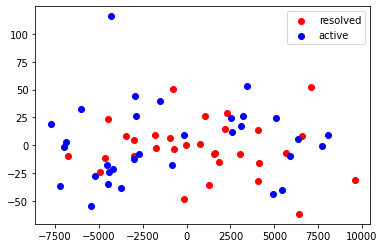

In [69]:
##plotting
print(X_2d.shape)
import matplotlib.pyplot as plt
plt.scatter(X_2d[data_labels == 0, 0], X_2d[data_labels == 0, 1], c='r', label='resolved')
plt.scatter(X_2d[data_labels == 1, 0], X_2d[data_labels == 1, 1], c='b', label='active')
plt.legend()
plt.show();

In [64]:
print(x_train.shape)
#print(y_train.shape)
import xgboost as xgb
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

eval_set = [(x_train, y_train), (x_test, y_test)]
model.fit(x_train, y_train, eval_metric=["logloss"],early_stopping_rounds= 10,
          eval_set=eval_set, verbose=False)

(50, 25729)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[1 1 1 0 1 0 0 0 0 0 1 1 0]
[0 1 0 1 1 0 1 0 1 1 1 1 1]
Accuracy: 0.46153846153846156


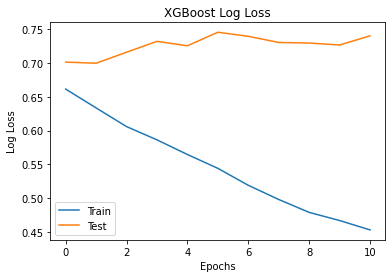

In [65]:
import matplotlib.pyplot as plt


# make predictions for test data
preds = model.predict(x_test)
print(preds)
print(y_test)
acc = np.mean(preds == y_test)
print(f"Accuracy: {acc}")

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()

